In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Read the data
df = pd.read_csv('../data/mydata.csv')

# Print the first few rows of the data
df.head()

/var/folders/0n/w0w76l850xd5bkqpcpl6v0rr0000gn/T/ipykernel_1119/93828000.py:7: DtypeWarning: Columns (3,5,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/mydata.csv')


,Unnamed: 0,issuer,domicile,state,notifying_party,domicile_not,total_participation_shares,participation_instruments,aggregation,publication,direct_participation,single_rights_1,attributable_participation,single_rights_2,single_rights_3,gazette_1,gazette_2,state_2,date,table_date
0,1,A.A.A. Aktiengesellschaft Allgemeine Anlagever...,Frankfurt am Main,NaN,ROTHENBERGER Vermögensverwaltung GbR 4xS,NaN,29.62,NaN,NaN,1999-05-11,29.62,NaN,NaN,NaN,NaN,Börsen-Zeitung,NaN,NaN,NaN,200001.0
1,2,A.A.A. Aktiengesellschaft Allgemeine Anlagever...,Frankfurt am Main,NaN,"Rothenberger, Dr., Helmut",NaN,11.93,NaN,NaN,1995-10-07,11.93,NaN,NaN,NaN,NaN,Börsen-Zeitung,NaN,NaN,NaN,200001.0
2,3,A.S. Création Tapeten Aktiengesellschaft,Gummersbach,NaN,"Schneider, Franz Jürgen",NaN,33.10,NaN,NaN,1998-07-08,33.10,NaN,NaN,NaN,NaN,Handelsblatt,NaN,NaN,NaN,200001.0
3,4,A.S. Création Tapeten Aktiengesellschaft,Gummersbach,NaN,3i Group plc,NaN,23.34,NaN,NaN,1998-07-08,0.00,NaN,23.34,NaN,NaN,Handelsblatt,NaN,NaN,NaN,200001.0
4,5,A.S. Création Tapeten Aktiengesellschaft,Gummersbach,NaN,3i Deutschland Gesellschaft für Industriebetei...,NaN,23.34,NaN,NaN,1998-07-08,23.34,NaN,NaN,NaN,NaN,Handelsblatt,NaN,NaN,NaN,200001.0


### Confusing NaN values

I noticed that some entries don't have a table date, it seems to disappear somewhere in between. I will plot that below and on that occasion also have a look at a few other columns.

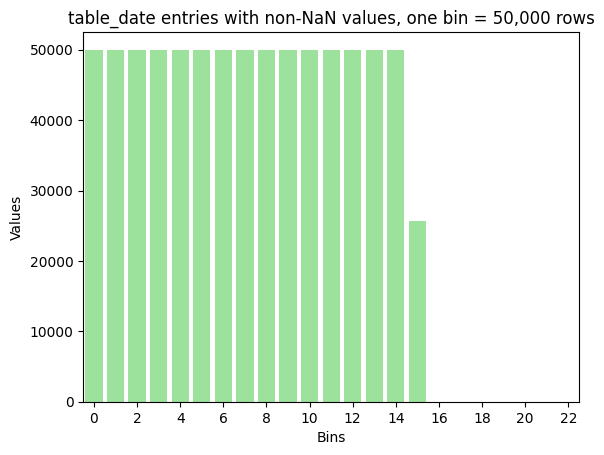

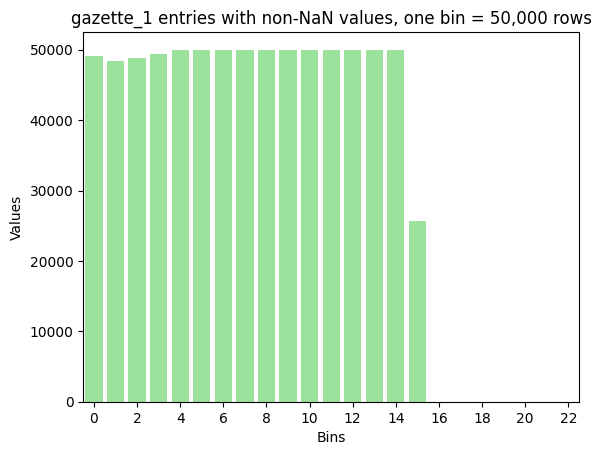

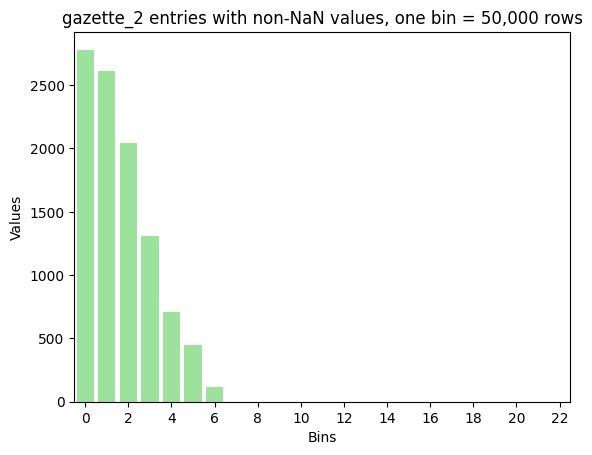

In [3]:
# Create bins, i.e. slices of the DataFrame, that each contain 50,000 rows

def plot_nan_values(column):
    bins = [df.index[i:i+50000] for i in range(0,len(df),50000)]

    # Create an empty list to store the counts of non-NaN values in the "table_date" column
    counts = []

    for bin in bins:
        # Slice the DataFrame for each bin
        df_bin = df.iloc[bin]
        # Count the number of non-NaN values in the "table_date" column
        count = df_bin[column].count()
        # Append the count to the list
        counts.append(count)

    # Print the counts for each bin
    #print(counts)

    data = {'Bins': list(range(0, len(counts))), 'Values': counts}
    plot_df = pd.DataFrame(data)

    sns.barplot(x='Bins', y='Values', data=plot_df, color='lightgreen')

    plt.xticks(np.arange(0, len(counts), 2))

    # Add labels and title
    plt.xlabel('Bins')
    plt.ylabel('Values')
    plt.title(str(column) + ' entries with non-NaN values, one bin = 50,000 rows')

    # Show the plot
    plt.show()

plot_nan_values('table_date')
plot_nan_values('gazette_1')
plot_nan_values('gazette_2')

# Consolidation

## Overview

In order to implement any of the rules, we need to consolidate the list of shareholders. First, I will group all entries by exact matches and sort them from the largest to smallest group. Then, I will create a plot that shows every 100th row of that sorted dataframe.



,notifying_party,counts
1858,"BlackRock, Inc.",9412
1172,Axxion S.A.,4951
3201,DWS Investment GmbH,4218
822,Allianz Global Investors GmbH,3636
12661,"The Capital Group Companies, Inc.",3251
13072,Universal-Investment-Gesellschaft mit beschrän...,3142
1392,Baden-Württembergische Versorgungsanstalt für ...,2926
7451,LBBW Asset Management Investmentgesellschaft mbH,2740
1846,"BlackRock Holdco 2, Inc.",2735
14169,"Zours, Wilhelm Konrad Thomas",2609


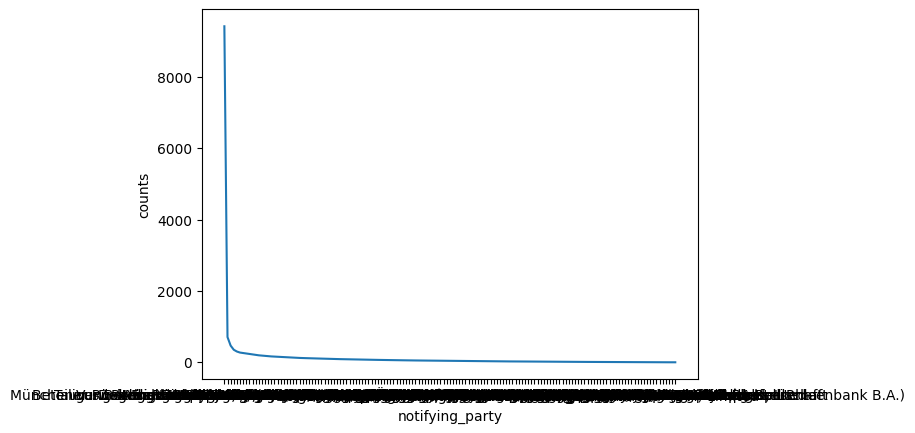

In [4]:
# group by notifying party and aggregate the number of entries
df_grouped = df.groupby(['notifying_party']).size().reset_index(name='counts')
# sort this dataframe by the number of entries
df_grouped = df_grouped.sort_values(by=['counts'], ascending=False)
# plot only every 100th entry to generate it faster
sns.lineplot(x='notifying_party', y='counts', data=df_grouped[::100])
df_grouped.head(20)


Among the shareholders with the highest numbers of records, there is a high number of asset managers. The largest groups also account for the bulk of the overall number of records. This can also be spot-checked by inserting a statement like df_grouped['counts'].iloc[some index, like 5846 or 11937 or 14101] below the line where dataframe is sorted.

## Challenges

In order to consolidate the list, it is necessary to find a balanced solution to two challenges: (1) Matching entries that are misspelled, but refer to the same shareholder, and (2) not matching those entries that sound similar, but refer to different companies. As a first step, it might be helpful to have a look at how often (1) occurs. (But creating similar groups might help because it's easier to find the similar values that way. Use this library and read up on it here: https://github.com/seatgeek/thefuzz)